In [1]:
import glob
import os
import re

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# --- FUNCTION to preprocess .txt files for consistent delimiters


def preprocess_txt(file_path):
    data = []  # Initialize a list to store the processed data

    # Initialize a flag to determine if we are reading the header
    is_header = True

    # Read the file line by line and process the data
    with open(file_path) as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if is_header:
                # Split the first line into column names
                column_names = re.split(r"\s+", line)
                is_header = False
            else:
                # Split the other lines into data values
                values = re.split(r"\s+", line)
                data.append(values)

    # Create a DataFrame with the processed data and set column names
    df = pd.DataFrame(data, columns=column_names)
    # return
    return df

In [6]:
# --- read in flux data from two runs
# flux data are colum integrated fluxes with all timesteps in a single file


# where results are stored
results_path = {
    "basalt": "example_3-3-15xRadius_site8",
    "calcite": "example_3-3-calcite-15xRadius_site8",
}

# define file name pattern
fn_pref = [
    "int_flx_co2sp",
    "flx_co2sp",
]  # will read in all species unless fn_varInclude is defined
fn_varInclude = []
varCheck = True if len(fn_varInclude) > 0 else False
fn_ext = ".txt"

# loop through runs
df = pd.DataFrame()  # initialize empty df to store dat
for key, run in results_path.items():
    # get these paths
    flx_path, prof_path = os.path.join(run, "flx"), os.path.join(run, "prof")

    # loop through variables
    for fset in fn_pref:
        # set pattern
        fn_pattern = f"{fset}-*{fn_ext}"
        # get list of filenames
        file_paths = glob.glob(f"{flx_path}/{fn_pattern}")

        # read in data and concatenate
        for file_path in file_paths:
            # get the variable
            varpattern = re.escape(fset) + r"-(.*?).txt"
            varmatch = re.search(varpattern, file_path)
            var = varmatch.group(1)
            # skip this step if it's not in the include arr
            if varCheck:
                if var not in fn_varInclude:
                    continue
            # read in
            dfi = preprocess_txt(file_path)
            # apply pd.to_numeric to all columns using the "map" method
            dfi = dfi.map(pd.to_numeric)
            # add set, var, and key
            dfi["set"] = fset
            dfi["var"] = var
            dfi["run_id"] = key
            # combine
            df = pd.concat([df, dfi], ignore_index=True)

# sort by time and depth
df = df.sort_values(by=["var", "time"])
df

,time,tflx,adv,dif,rain,amsi,cc,dlm,tm,ka,...,g2,fo,an,fa,gt,fe2o2,res,set,var,run_id
248,0.001111,-0.324426,0.352313,6.191943e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000454,int_flx_co2sp,ALK,basalt
620,0.001111,-0.323062,0.351034,6.140164e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000447,flx_co2sp,ALK,basalt
1000,0.001311,-0.099219,0.351832,7.600176e-05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000129,int_flx_co2sp,ALK,calcite
1384,0.001311,-0.041706,0.348539,9.666819e-05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000015,flx_co2sp,ALK,calcite
1001,0.003182,0.162335,0.338278,2.699628e-04,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.002243,int_flx_co2sp,ALK,calcite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,115.067818,0.001267,1.543319,1.662747e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.025217,flx_co2sp,hco3,basalt
123,120.139239,0.003007,1.031134,2.058182e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.012988,int_flx_co2sp,hco3,basalt
495,120.139239,0.001193,1.572320,1.630862e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.026164,flx_co2sp,hco3,basalt
871,120.295052,0.009096,3.064644,2.457202e-05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.100314,int_flx_co2sp,hco3,calcite


In [7]:
# --- compute the change in CO2 relative to t=0 in diffusion and advection
#     [for now I'll take the minimum value and subtract that out to account for a blip (maybe numerical?) at first timestep)]
# create new column
pvars = ["co2g", "DIC"]
flxtype = ["dif", "adv"]  # these align with pvars

# get set of unique ids / sets
unique_groups = df[["set", "run_id"]].drop_duplicates()

# loop through pvars
outdf = pd.DataFrame()  # initialize empty df to store dat
for tdx in range(len(pvars)):
    thisvar = pvars[tdx]
    thisflx = flxtype[tdx]
    thiscolname = thisflx + "_" + thisvar + "_change"
    df[thiscolname] = 0.0  # initialize column

    # loop through sets
    for idx, dset in unique_groups.iterrows():
        # subset data
        cond = (
            (df["set"] == dset["set"])
            & (df["run_id"] == dset["run_id"])
            & (df["var"] == thisvar)
        )
        dfx = df[cond]
        # get initial flux
        # diff_init = dfx.loc[dfx['time'].idxmin(), thisflx]
        if thisflx == "dif":  # start with max
            diff_init = dfx[thisflx].max()
        else:
            diff_init = dfx[thisflx].min()
        # fill in new column
        df.loc[cond, thiscolname] = df.loc[cond, thisflx] - diff_init

df

,time,tflx,adv,dif,rain,amsi,cc,dlm,tm,ka,...,an,fa,gt,fe2o2,res,set,var,run_id,dif_co2g_change,adv_DIC_change
248,0.001111,-0.324426,0.352313,6.191943e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000454,int_flx_co2sp,ALK,basalt,0.0,0.0
620,0.001111,-0.323062,0.351034,6.140164e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000447,flx_co2sp,ALK,basalt,0.0,0.0
1000,0.001311,-0.099219,0.351832,7.600176e-05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000129,int_flx_co2sp,ALK,calcite,0.0,0.0
1384,0.001311,-0.041706,0.348539,9.666819e-05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000015,flx_co2sp,ALK,calcite,0.0,0.0
1001,0.003182,0.162335,0.338278,2.699628e-04,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.002243,int_flx_co2sp,ALK,calcite,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,115.067818,0.001267,1.543319,1.662747e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.025217,flx_co2sp,hco3,basalt,0.0,0.0
123,120.139239,0.003007,1.031134,2.058182e-06,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.012988,int_flx_co2sp,hco3,basalt,0.0,0.0
495,120.139239,0.001193,1.572320,1.630862e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.026164,flx_co2sp,hco3,basalt,0.0,0.0
871,120.295052,0.009096,3.064644,2.457202e-05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.100314,int_flx_co2sp,hco3,calcite,0.0,0.0


In [8]:
# --- compute CDR following Kanzaki / Baek (not accounting for respiration change here because T is held constant)
difcol, advcol = "dif_co2g_change", "adv_DIC_change"
difvar, advvar = "co2g", "DIC"
adv_lossFactor = 0  # fraction of advected C that we lose (Baek et al., 2023 use 0.14)

# assign CDR potentials for each rock (mass per mass)
cc_rco2 = 0.6  # PLACEHOLDER guesses
ba_rco2 = 0.3  # PLACEHOLDER guesses
appRate = 40  # ton rock / ha / yr
# loop through sets
outdf = pd.DataFrame()  # initialize empty df to store dat
for idx, dset in unique_groups.iterrows():
    # set rco2
    if dset["run_id"] == "calcite":
        rco2 = cc_rco2
    else:
        rco2 = ba_rco2

    # subset data
    dif_cond = (
        (df["set"] == dset["set"])
        & (df["run_id"] == dset["run_id"])
        & (df["var"] == difvar)
    )
    adv_cond = (
        (df["set"] == dset["set"])
        & (df["run_id"] == dset["run_id"])
        & (df["var"] == advvar)
    )
    # create output df
    dif_df = df.loc[dif_cond, ["time", difcol]]
    adv_df = df.loc[adv_cond, ["time", advcol]]
    outdf_i = pd.merge(dif_df, adv_df, on="time", how="outer")
    # compute cdr
    outdf_i["cdr_mol_m2_yr"] = -1 * outdf_i[difcol] + outdf_i[advcol] * (
        1 - adv_lossFactor
    )
    outdf_i["cdrAdv_mol_m2_yr"] = outdf_i[advcol] * (1 - adv_lossFactor)

    # compute theoretical max
    outdf_i["cdrMax_ton_ha_yr"] = appRate * rco2

    # apply 50% calcite haircut
    if dset["run_id"] == "calcite":
        outdf_i["cdr_mol_m2_yr"] = outdf_i["cdr_mol_m2_yr"] / 2
        outdf_i["cdrAdv_mol_m2_yr"] = outdf_i["cdrAdv_mol_m2_yr"] / 2

    # add set
    outdf_i["set"] = dset["set"]
    outdf_i["run_id"] = dset["run_id"]
    # get output dataset
    outdf = pd.concat([outdf, outdf_i], ignore_index=True)

# convert to tons / ha / yr
co2_g_mol = 44.01
ton_g = 1 / 1e6
m2_ha = 10e3
outdf["cdr_ton_ha_yr"] = outdf["cdr_mol_m2_yr"] * co2_g_mol * ton_g * m2_ha
outdf["cdrAdv_ton_ha_yr"] = outdf["cdrAdv_mol_m2_yr"] * co2_g_mol * ton_g * m2_ha

In [9]:
# get cumulative and potential cdr
# def integrate(x):
#     return cumtrapz(x, initial=0)
# outdf['cdrAdv_integrated_ton_ha'] = outdf.groupby(['run_id', 'set'])['cdrAdv_ton_ha_yr'].transform(integrate)
# outdf['cdrMax_ton_ha'] = outdf.groupby(['run_id', 'set'])['cdrMax_ton_ha_yr'].transform(integrate)

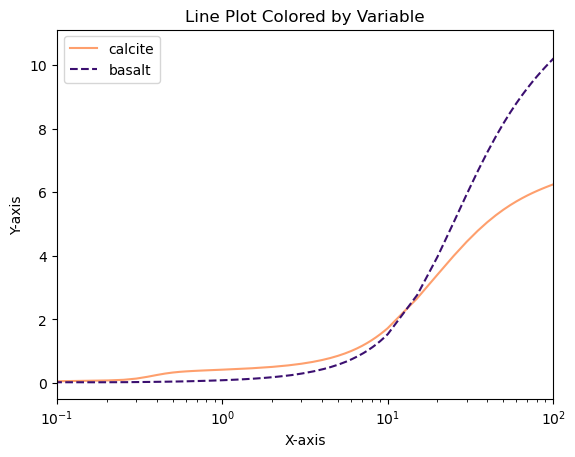

In [11]:
# --- plot CDR per year (lines colored by the set)
cdvar = "cdrAdv_ton_ha_yr"  # variable to plot

# aesthetics
logX = True
logY = False
mycmap = "magma"  # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# split into basalt and calcite continuous fluxes
dfcc_cont = outdf[(outdf["set"] == "flx_co2sp") & (outdf["run_id"] == "calcite")]
dfbas_cont = outdf[(outdf["set"] == "flx_co2sp") & (outdf["run_id"] == "basalt")]
# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
# split by set
plt.plot(
    dfcc_cont["time"], dfcc_cont[cdvar], color=cmap(0.2), label="calcite", linestyle="-"
)
plt.plot(
    dfbas_cont["time"],
    dfbas_cont[cdvar],
    color=cmap(0.8),
    label="basalt",
    linestyle="--",
)

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
if logX:
    plt.xscale("log")
    plt.xlim([0.1, 100])
if logY:
    plt.yscale("log")
    plt.ylim([0.0001, 15])
plt.title("Line Plot Colored by Variable")
# Add legend
plt.legend()
plt.show();

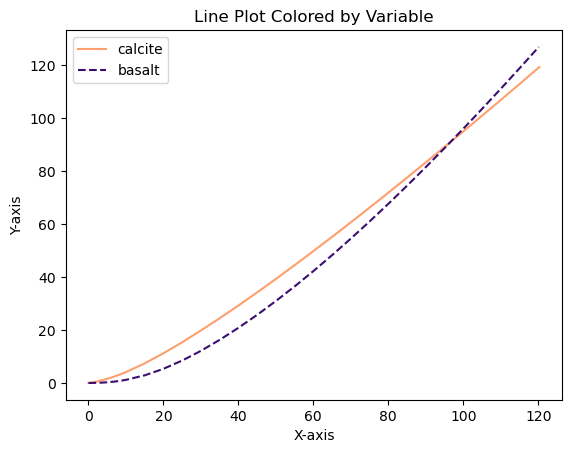

In [30]:
# --- plot CDR cumulative (lines colored by the set)
cdvar = "cdrAdv_ton_ha_yr"  # variable to plot

# aesthetics
logX = False
logY = False
mycmap = "magma"  # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# split into basalt and calcite continuous fluxes
dfcc_int = outdf[(outdf["set"] == "int_flx_co2sp") & (outdf["run_id"] == "calcite")]
dfbas_int = outdf[(outdf["set"] == "int_flx_co2sp") & (outdf["run_id"] == "basalt")]
# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
# split by set
plt.plot(
    dfcc_int["time"],
    dfcc_int[cdvar] * dfcc_int["time"],
    color=cmap(0.2),
    label="calcite",
    linestyle="-",
)
plt.plot(
    dfbas_int["time"],
    dfbas_int[cdvar] * dfbas_int["time"],
    color=cmap(0.8),
    label="basalt",
    linestyle="--",
)

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
if logX:
    plt.xscale("log")
    plt.xlim([0.1, 100])
if logY:
    plt.yscale("log")
    plt.ylim([0.0001, 15])
plt.title("Line Plot Colored by Variable")
# Add legend
plt.legend()
plt.show();

In [ ]:
# --- plot CDR relative to potential
cdvar = "cdrAdv_integrated_ton_ha"  # variable to plot
cdvarMax = "cdrMax_ton_ha"

# aesthetics
logX = False
logY = False
mycmap = "magma"  # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# plot prep
grouped = outdf.groupby("run_id")
num_sets = len(grouped)
# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
for i, (name, group) in enumerate(grouped):
    cmap_percentage = start_percentage + i * (end_percentage - start_percentage) / (
        num_sets - 1
    )
    color = cmap(cmap_percentage)
    # split by set
    g1 = group[group["set"] == "int_flx_co2sp"]
    g2 = group[group["set"] == "flx_co2sp"]
    plt.plot(g1["time"], g1[cdvar], color=color, label=name, linestyle="-")
    plt.plot(g1["time"], g1[cdvarMax], color=color, label=name, linestyle="--")
    # plt.plot(g2['time'], g2[cdvar], color=color, label=name, linestyle="--")

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
if logX:
    plt.xscale("log")
    plt.xlim([0.1, 100])
if logY:
    plt.yscale("log")
    plt.ylim([0.0001, 15])
plt.title("Line Plot Colored by Variable")
# Add legend
plt.legend()
plt.show();

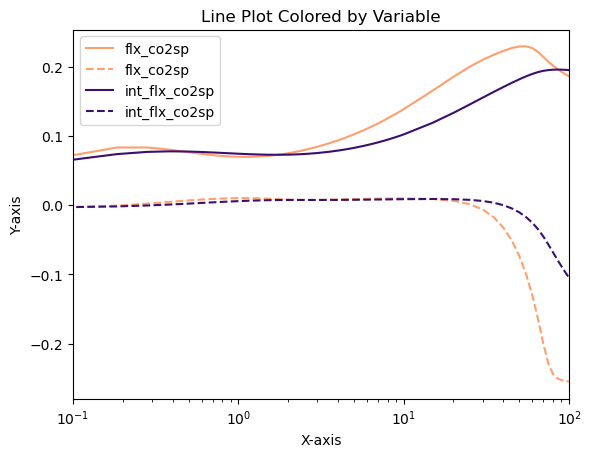

In [20]:
# --- plot individual contributions to CDR
difcol, advcol = "dif_co2g_change", "adv_DIC_change"  # variable to plot
cdvar = "cdr_ton_ha_yr"  # variable to plot

# aesthetics
logX = True
logY = False
mycmap = "magma"  # name of colormap
# cmap start and end percentages
start_percentage = 0.2
end_percentage = 0.8

# plot prep
grouped = outdf.groupby("set")
num_sets = len(grouped)
# colormap
cmap = plt.get_cmap(mycmap)  # Get the colormap
cmap = cmap.reversed()  # flip colormap
# -- no log normalization
norm = plt.Normalize(
    df["time"].min(), df["time"].max()
)  # Normalize time values for colormap


# --- PLOT
# Create a plot for each time step
for i, (name, group) in enumerate(grouped):
    cmap_percentage = start_percentage + i * (end_percentage - start_percentage) / (
        num_sets - 1
    )
    color = cmap(cmap_percentage)
    plt.plot(group["time"], group[difcol] * -1, color=color, label=name, linestyle="-")
    plt.plot(
        group["time"],
        group[advcol] * (1 - adv_lossFactor),
        color=color,
        label=name,
        linestyle="--",
    )


# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
if logX:
    plt.xscale("log")
    plt.xlim([0.1, 100])
if logY:
    plt.yscale("log")
    plt.ylim([0.00001, 25])
plt.title("Line Plot Colored by Variable")
# Add legend
plt.legend()
plt.show();

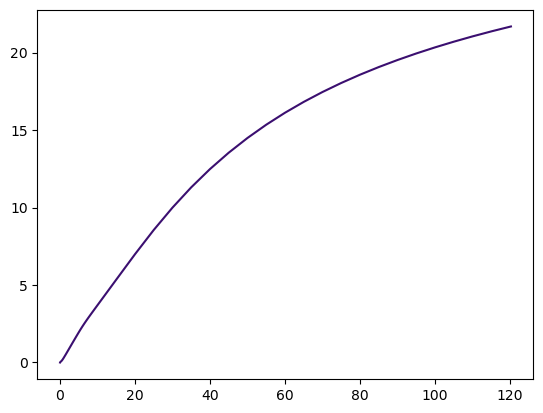

In [171]:
plt.plot(group["time"], group[cdvar], color=color, label=name)

In [170]:
group

,time,dif_co2g_change,adv_DIC_change,cdr_mol_m2_yr,set,cdr_ton_ha_yr
0,0.001111,0.000000,0.000000e+00,0.000000,int_flx_co2sp,0.000000
1,0.003026,-0.002024,9.777405e-07,0.002025,int_flx_co2sp,0.000891
2,0.010069,-0.005748,2.196623e-05,0.005770,int_flx_co2sp,0.002540
3,0.030576,-0.012755,1.611817e-04,0.012916,int_flx_co2sp,0.005684
4,0.050194,-0.017698,3.304539e-04,0.018028,int_flx_co2sp,0.007934
...,...,...,...,...,...,...
59,100.028801,-16.360641,3.978193e+00,20.338834,int_flx_co2sp,8.951121
60,105.019451,-16.667042,4.037652e+00,20.704693,int_flx_co2sp,9.112135
61,110.010101,-16.953145,4.094122e+00,21.047267,int_flx_co2sp,9.262902
62,115.271717,-17.235073,4.150706e+00,21.385780,int_flx_co2sp,9.411882


In [135]:
# subset data
pvar = "co2g"
colname = "dif_" + pvar + "_change"
df[colname] = 0.0

cond = (df["set"] == "int_flx_co2sp") & (df["var"] == "co2g")
dfx = df[cond]
# get initial flux
diff_init = dfx.loc[dfx["time"].idxmin(), "dif"]
# fill in new column
df.loc[cond, colname] = df.loc[cond, "dif"] - diff_init
df.loc[cond, colname]

0      0.000000
1     -0.002024
2     -0.005748
3     -0.012755
4     -0.017698
        ...    
59   -16.360641
60   -16.667042
61   -16.953145
62   -17.235073
63   -17.487820
Name: dif_co2g_change, Length: 64, dtype: float64